# Practice-0

In [1]:
# https://github.com/openai/gym/wiki/CartPole-v0
import gym

env = gym.make('CartPole-v0')
env.reset()
episode = 0
reward_sum = 0
num_actions = 0

# x : -0.061586
# θ : -0.75893141
# dx/dt : 0.05793238
# dθ/dt : 1.15547541

while episode < 10:
    env.render()
    action = env.action_space.sample()
    num_actions += 1
    new_state, reward, done, info = env.step(action)
    print("Action {0}: {1} --> State: {2}, Reward: {3}, Done: {4}, Info: {5}".format(num_actions, action, new_state, reward, done, info))
    reward_sum += reward
    if done:
        print("Total reward for this episode {0} was: {1}".format(episode, reward_sum))
        reward_sum = 0
        env.reset()
        input("Press Enter to continue...")
        episode += 1
        num_actions = 1

[2017-05-14 23:15:34,175] Making new env: CartPole-v0


Action 1: 0 --> State: [-0.01205741 -0.2124622   0.04811635  0.33995526], Reward: 1.0, Done: False, Info: {}
Action 2: 1 --> State: [-0.01630666 -0.01805672  0.05491545  0.0628253 ], Reward: 1.0, Done: False, Info: {}
Action 3: 1 --> State: [-0.01666779  0.17623662  0.05617196 -0.21203835], Reward: 1.0, Done: False, Info: {}
Action 4: 0 --> State: [-0.01314306 -0.01964158  0.05193119  0.09782142], Reward: 1.0, Done: False, Info: {}
Action 5: 1 --> State: [-0.01353589  0.17469911  0.05388762 -0.17803572], Reward: 1.0, Done: False, Info: {}
Action 6: 1 --> State: [-0.01004191  0.36901014  0.05032691 -0.45324389], Reward: 1.0, Done: False, Info: {}
Action 7: 1 --> State: [-0.00266171  0.56338564  0.04126203 -0.72964811], Reward: 1.0, Done: False, Info: {}
Action 8: 1 --> State: [ 0.00860601  0.75791371  0.02666907 -1.00906426], Reward: 1.0, Done: False, Info: {}
Action 9: 1 --> State: [ 0.02376428  0.95266973  0.00648778 -1.29325463], Reward: 1.0, Done: False, Info: {}
Action 10: 1 --> St

# Practice-1

[2017-05-14 23:17:41,501] Making new env: CartPole-v0


episode: 0, Epsilon: 0.495, Evaluation Average Reward: 81.8
episode: 100, Epsilon: 0.18118600893024847, Evaluation Average Reward: 54.8
episode: 200, Epsilon: 0.06631993905469107, Evaluation Average Reward: 53.0
episode: 300, Epsilon: 0.02427524256528645, Evaluation Average Reward: 46.8
episode: 400, Epsilon: 0.008885523871147341, Evaluation Average Reward: 48.2
episode: 500, Epsilon: 0.0032523891059952296, Evaluation Average Reward: 56.8
episode: 600, Epsilon: 0.0011904795991989781, Evaluation Average Reward: 33.9
episode: 700, Epsilon: 0.00043575403493281765, Evaluation Average Reward: 44.7
episode: 800, Epsilon: 0.00015950006962571568, Evaluation Average Reward: 35.3
episode: 900, Epsilon: 5.838218391834379e-05, Evaluation Average Reward: 37.1
episode: 1000, Epsilon: 2.1369767468275632e-05, Evaluation Average Reward: 34.0
episode: 1100, Epsilon: 7.82202601887742e-06, Evaluation Average Reward: 39.7
episode: 1200, Epsilon: 2.8631144971898185e-06, Evaluation Average Reward: 34.2
episo

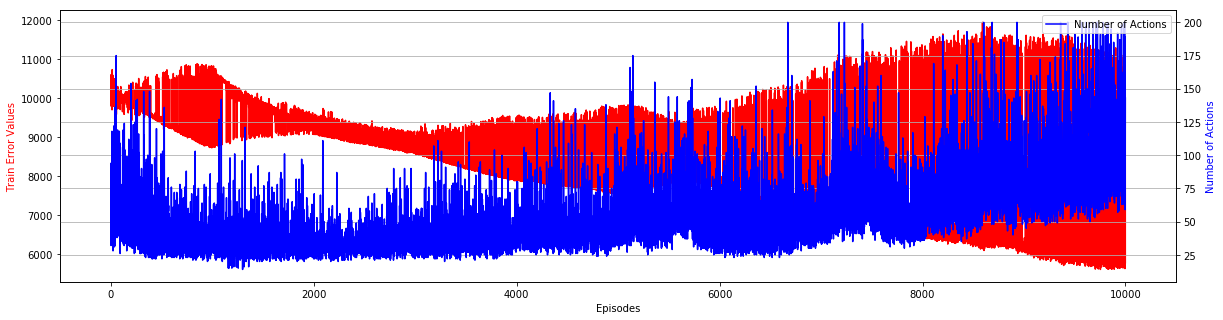

Press Enter to close the trained error figure...
Press Enter to make the trained bot play...


In [2]:
# -*- coding: utf-8 -*-
# https://github.com/openai/gym/wiki/CartPole-v0
import tensorflow as tf
import gym
import numpy as np
import matplotlib.pyplot as plt

# 리플레이를 저장할 리스트
REPLAY_MEMORY = []

# 미니배치 - 꺼내서 사용할 리플레이 갯수
MINIBATCH = 50

# 하이퍼파라미터
INITIAL_EPSILON = 0.5
learning_rate = 0.0001
max_episodes = 10000
discount_factor = 0.9
episode_list = []
train_error_list = []
actions_list = []

# 테스트 에피소드 주기
TEST_PERIOD = 100

# 네트워크 클래스 구성
class DQN:
    def __init__(self, session, input_size, output_size, name="main"):
        # 네트워크 정보 입력
        self.session = session
        self.input_size = input_size
        self.output_size = output_size
        self.net_name = name
        self.hidden_size = 20
        # 네트워크 생성
        self.build_network()

    def build_network(self):
        # Vanilla Neural Network (Just one hidden layer)
        self.X = tf.placeholder(shape=[None, self.input_size], dtype=tf.float32)
        self.Y = tf.placeholder(shape=[None], dtype=tf.float32)

        self.W1 = tf.Variable(tf.truncated_normal(shape=[self.input_size, self.hidden_size], mean=0.0, stddev=1.0))
        self.B1 = tf.Variable(tf.zeros(shape=[self.hidden_size]))
        self.W2 = tf.Variable(tf.truncated_normal(shape=[self.hidden_size, self.output_size], mean=0.0, stddev=1.0))
        self.B2 = tf.Variable(tf.zeros(shape=[self.output_size]))

        self.L1 = tf.nn.tanh(tf.matmul(self.X, self.W1) + self.B1)

        self.Qpred = tf.matmul(self.L1, self.W2) + self.B2

        # 손실 함수 및 최적화 함수
        self.action = tf.placeholder(shape=[None, self.output_size], dtype=tf.float32)
        Q_action = tf.reduce_sum(tf.multiply(self.Qpred, self.action), reduction_indices=1)
        self.loss = tf.reduce_mean(tf.square(self.Y - Q_action))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)

    # 예측한 Q값 구하기
    def predict(self, state):
        x = np.reshape(state, newshape=[1, self.input_size])
        return self.session.run(self.Qpred, feed_dict={self.X: x})

    # e-greedy 를 사용하여 action값 구함
    def egreedy_action(self, epsilon, env, state):
        if np.random.rand(1) < epsilon:
            action = env.action_space.sample()
            #print("Episode: {0}, Action: {1}".format(episode, action))
        else:
            Q_h = self.predict(state)
            action = np.argmax(Q_h)
            #print("Episode: {0}, State: {1}, Q_h: {2}, Action: {3}".format(episode, state, Q_h, action))
        return action

    # 네트워크 학습
    def update(self, state, new_state, action):
        x = np.reshape(state, newshape=[1, self.input_size])
        if done:
            # it's a terminal state
            y = -100
        else:
            # Obtain the Q_y values by feeding the new state through the network
            y = reward + discount_factor * np.max(self.predict(new_state))

        one_hot_action = np.zeros(self.output_size)
        one_hot_action[action] = 1
        one_hot_action = np.reshape(one_hot_action, newshape=[1, self.output_size])

        loss_value, _ = self.session.run([self.loss, self.optimizer], feed_dict={self.X: x, self.Y: [y], self.action: one_hot_action})
        return loss_value


def bot_play(DQN, env):
    """
    See our trained network in action
    """
    state = env.reset()
    reward_sum = 0
    done = False
    while not done:
        env.render()
        action = np.argmax(DQN.predict(state))
        new_state, reward, done, info = env.step(action)
        reward_sum += reward
        state = new_state

    return reward_sum



def draw_error_values():
    fig = plt.figure(figsize=(20, 5))
    plt.ion()
    ax1 = plt.subplot(111)
    ax2 = ax1.twinx()
    ax1.plot(episode_list[0:], train_error_list[0:], 'r', label='Train Error Values')
    ax2.plot(episode_list[0:], actions_list[0:], 'b', label='Number of Actions')
    ax1.set_ylabel('Train Error Values', color='r')
    ax2.set_ylabel('Number of Actions', color='b')
    ax1.set_xlabel('Episodes')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()
    input("Press Enter to close the trained error figure...")
    plt.close(fig)

if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    input_size = env.observation_space.shape[0]     # 4
    output_size = env.action_space.n                # 2

    with tf.Session() as sess:
        # DQN 클래스의 mainDQN 인스턴스 생성
        mainDQN = DQN(sess, input_size, output_size)

        # 변수 초기화
        init = tf.global_variables_initializer()
        sess.run(init)
        epsilon = INITIAL_EPSILON

        for episode in range(max_episodes):
            state = env.reset()
            rAll = 0
            done = False
            epsilon *= 0.99

            while not done:
                # action을 수행함 --> Get new state and reward from environment
                action = mainDQN.egreedy_action(epsilon, env, state)
                new_state, reward, done, _ = env.step(action)

                loss_value = mainDQN.update(state, new_state, action)

                rAll += reward
                state = new_state

            episode_list.append(episode)
            train_error_list.append(loss_value)
            actions_list.append(rAll)

            if episode % TEST_PERIOD == 0:
                total_reward = 0
                for i in range(10):
                    total_reward += bot_play(mainDQN, env)

                ave_reward = total_reward / 10
                print("episode: {0}, Epsilon: {1}, Evaluation Average Reward: {2}".format(episode,epsilon, ave_reward))
                if ave_reward >= 200:
                    break

            # time.sleep(1) # delays for 1 second between episodes

        env.reset()
        env.close()
        draw_error_values()

        input("Press Enter to make the trained bot play...")
        bot_play(mainDQN, env)

# Practice-2

[2017-05-15 11:48:58,988] Making new env: CartPole-v0


episode: 0, Epsilon: 0.495, Evaluation Average Reward: 13.8
episode: 100, Epsilon: 0.18118600893024847, Evaluation Average Reward: 28.1
episode: 200, Epsilon: 0.06631993905469107, Evaluation Average Reward: 9.6
episode: 300, Epsilon: 0.02427524256528645, Evaluation Average Reward: 10.0
episode: 400, Epsilon: 0.008885523871147341, Evaluation Average Reward: 9.5
episode: 500, Epsilon: 0.0032523891059952296, Evaluation Average Reward: 9.7
episode: 600, Epsilon: 0.0011904795991989781, Evaluation Average Reward: 9.6
episode: 700, Epsilon: 0.00043575403493281765, Evaluation Average Reward: 10.6
episode: 800, Epsilon: 0.00015950006962571568, Evaluation Average Reward: 12.1
episode: 900, Epsilon: 5.838218391834379e-05, Evaluation Average Reward: 21.0
episode: 1000, Epsilon: 2.1369767468275632e-05, Evaluation Average Reward: 28.8
episode: 1100, Epsilon: 7.82202601887742e-06, Evaluation Average Reward: 29.6
episode: 1200, Epsilon: 2.8631144971898185e-06, Evaluation Average Reward: 33.2
episode: 

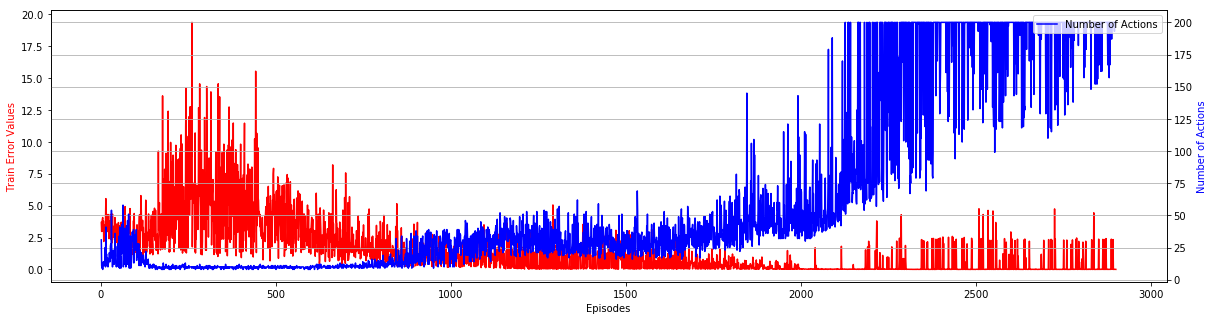

Press Enter to close the trained error figure...
Press Enter to make the trained bot play...


In [1]:
# -*- coding: utf-8 -*-
# https://github.com/openai/gym/wiki/CartPole-v0
import tensorflow as tf
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

# 리플레이를 저장할 리스트
REPLAY_MEMORY = deque()

# 하이퍼파라미터
INITIAL_EPSILON = 0.5
learning_rate = 0.0001
max_episodes = 10000
discount_factor = 0.9
episode_list = []
train_error_list = []
actions_list = []

# 테스트 에피소드 주기
TEST_PERIOD = 100

# 네트워크 클래스 구성
class DQN:
    def __init__(self, session, input_size, output_size, name="main"):
        # 네트워크 정보 입력
        self.session = session
        self.input_size = input_size
        self.output_size = output_size
        self.net_name = name
        self.hidden_size = 20
        # 네트워크 생성
        self.build_network()

    def build_network(self):
        # Vanilla Neural Network (Just one hidden layer)
        self.X = tf.placeholder(shape=[None, self.input_size], dtype=tf.float32)
        self.Y = tf.placeholder(shape=[None], dtype=tf.float32)

        W1 = tf.Variable(tf.truncated_normal(shape=[self.input_size, self.hidden_size], mean=0.0, stddev=1.0))
        B1 = tf.Variable(tf.zeros(shape=[self.hidden_size]))
        W2 = tf.Variable(tf.truncated_normal(shape=[self.hidden_size, self.output_size], mean=0.0, stddev=1.0))
        B2 = tf.Variable(tf.zeros(shape=[self.output_size]))

        L1 = tf.nn.relu(tf.matmul(self.X, W1) + B1)

        self.Qpred = tf.matmul(L1, W2) + B2

        # 손실 함수 및 최적화 함수
        self.action = tf.placeholder(shape=[None, self.output_size], dtype=tf.float32)
        Q_action = tf.reduce_sum(tf.multiply(self.Qpred, self.action), reduction_indices=1)
        self.loss = tf.reduce_mean(tf.square(self.Y - Q_action))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)

    # 예측한 Q값 구하기
    def predict(self, state):
        x = np.reshape(state, newshape=[1, self.input_size])
        return self.session.run(self.Qpred, feed_dict={self.X: x})

    # e-greedy 를 사용하여 action값 구함
    def egreedy_action(self, epsilon, env, state):
        if np.random.rand(1) < epsilon:
            action = env.action_space.sample()
            #print("Episode: {0}, Action: {1}".format(episode, action))
        else:
            Q_h = self.predict(state)
            action = np.argmax(Q_h)
            #print("Episode: {0}, State: {1}, Q_h: {2}, Action: {3}".format(episode, state, Q_h, action))
        return action

    def update_from_memory(self, batch_size):
        state_batch = np.ndarray(shape=[batch_size, self.input_size])
        action_batch = np.ndarray(shape=[batch_size, self.output_size])

        minibatch = random.sample(REPLAY_MEMORY, batch_size)
        i = 0
        y_batch = []
        for sample in minibatch:
            state, action, reward, new_state, done = sample         # unpacking

            if done:
                y_batch.append(reward)
            else:
                y_batch.append(reward + discount_factor * np.max(self.predict(new_state)))

            one_hot_action = np.zeros(self.output_size) # [0.0, 0.0]
            one_hot_action[action] = 1

            state_batch[i] = state
            action_batch[i] = one_hot_action
            i += 1

        # DQN 알고리즘으로 학습
        loss_value, _ = self.session.run([self.loss, self.optimizer],
                                 feed_dict={self.X: state_batch, self.Y: y_batch, self.action: action_batch})
        return loss_value

def bot_play(DQN, env):
    """
    See our trained network in action
    """
    state = env.reset()
    reward_sum = 0
    done = False
    while not done:
        env.render()
        action = np.argmax(DQN.predict(state))
        new_state, reward, done, info = env.step(action)
        reward_sum += reward
        state = new_state

    return reward_sum

def draw_error_values():
    fig = plt.figure(figsize=(20, 5))
    plt.ion()
    ax1 = plt.subplot(111)
    ax2 = ax1.twinx()
    ax1.plot(episode_list[0:], train_error_list[0:], 'r', label='Train Error Values')
    ax2.plot(episode_list[0:], actions_list[0:], 'b', label='Number of Actions')
    ax1.set_ylabel('Train Error Values', color='r')
    ax2.set_ylabel('Number of Actions', color='b')
    ax1.set_xlabel('Episodes')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()
    input("Press Enter to close the trained error figure...")
    plt.close(fig)

if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    input_size = env.observation_space.shape[0]     # 4
    output_size = env.action_space.n                # 2

    # 미니배치 - 꺼내서 사용할 리플레이 갯수
    BATCH_SIZE = 32

    with tf.Session() as sess:
        # DQN 클래스의 mainDQN 인스턴스 생성
        mainDQN = DQN(sess, input_size, output_size)

        # 변수 초기화
        init = tf.global_variables_initializer()
        sess.run(init)
        epsilon = INITIAL_EPSILON

        for episode in range(max_episodes):
            state = env.reset()
            rAll = 0
            done = False
            epsilon *= 0.99

            while not done:
                # action을 수행함 --> Get new state and reward from environment
                action = mainDQN.egreedy_action(epsilon, env, state)
                new_state, reward, done, _ = env.step(action)

                # state, action, reward, next_state, done 을 메모리에 저장
                REPLAY_MEMORY.append((state, action, reward, new_state, done))

                # 메모리에 10000개 이상의 값이 들어가면 가장 먼저 들어간 것부터 삭제
                if len(REPLAY_MEMORY) > 10000:
                    REPLAY_MEMORY.popleft()

                # REPLAY_MEMORY 크기가 BATCH_SIZE 보다 크면 학습
                if len(REPLAY_MEMORY) > BATCH_SIZE:
                    mean_loss_value = mainDQN.update_from_memory(BATCH_SIZE)

                rAll += reward
                state = new_state

            if len(REPLAY_MEMORY) > BATCH_SIZE:
                episode_list.append(episode)
                train_error_list.append(mean_loss_value)
                actions_list.append(rAll)

            if episode % TEST_PERIOD == 0:
                total_reward = 0
                for i in range(10):
                    total_reward += bot_play(mainDQN, env)

                ave_reward = total_reward / 10
                print("episode: {0}, Epsilon: {1}, Evaluation Average Reward: {2}".format(episode,epsilon, ave_reward))
                if ave_reward >= 200:
                    break

        env.reset()
        env.close()
        draw_error_values()

        input("Press Enter to make the trained bot play...")
        bot_play(mainDQN, env)

# Practice-3

[2017-05-15 12:33:30,230] Making new env: CartPole-v0


episode: 0, Epsilon: 0.495, Evaluation Average Reward: 56.9
episode: 100, Epsilon: 0.18118600893024847, Evaluation Average Reward: 9.4
episode: 200, Epsilon: 0.06631993905469107, Evaluation Average Reward: 9.2
episode: 300, Epsilon: 0.02427524256528645, Evaluation Average Reward: 9.3
episode: 400, Epsilon: 0.008885523871147341, Evaluation Average Reward: 9.3
episode: 500, Epsilon: 0.0032523891059952296, Evaluation Average Reward: 9.1
episode: 600, Epsilon: 0.0011904795991989781, Evaluation Average Reward: 9.6
episode: 700, Epsilon: 0.00043575403493281765, Evaluation Average Reward: 10.1
episode: 800, Epsilon: 0.00015950006962571568, Evaluation Average Reward: 10.8
episode: 900, Epsilon: 5.838218391834379e-05, Evaluation Average Reward: 26.2
episode: 1000, Epsilon: 2.1369767468275632e-05, Evaluation Average Reward: 49.0
episode: 1100, Epsilon: 7.82202601887742e-06, Evaluation Average Reward: 63.6
episode: 1200, Epsilon: 2.8631144971898185e-06, Evaluation Average Reward: 92.3
episode: 13

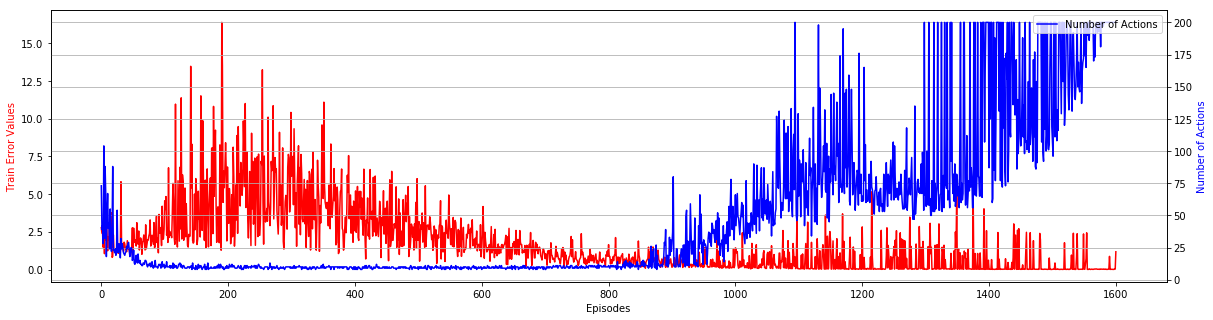

Press Enter to close the trained error figure...
Press Enter to make the trained bot play...


In [2]:
# -*- coding: utf-8 -*-
# https://github.com/openai/gym/wiki/CartPole-v0
import tensorflow as tf
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

# 리플레이를 저장할 리스트
REPLAY_MEMORY = deque()

# 하이퍼파라미터
INITIAL_EPSILON = 0.5
learning_rate = 0.0001
max_episodes = 10000
discount_factor = 0.9
episode_list = []
train_error_list = []
actions_list = []

# 테스트 에피소드 주기
TEST_PERIOD = 100

# src model에서 target model로 trainable variable copy 주기
COPY_PERIOD = 10

# 네트워크 클래스 구성
class DQN:
    def __init__(self, session, input_size, output_size, name="main"):
        # 네트워크 정보 입력
        self.session = session
        self.input_size = input_size
        self.output_size = output_size
        self.net_name = name
        self.hidden_size = 20
        # 네트워크 생성
        self.build_network()

    def build_network(self):
        with tf.variable_scope(self.net_name):
            # Vanilla Neural Network (Just one hidden layer)
            self.X = tf.placeholder(shape=[None, self.input_size], dtype=tf.float32)
            self.Y = tf.placeholder(shape=[None], dtype=tf.float32)

            self.W1 = tf.Variable(tf.truncated_normal(shape=[self.input_size, self.hidden_size], mean=0.0, stddev=1.0))
            self.B1 = tf.Variable(tf.zeros(shape=[self.hidden_size]))
            self.W2 = tf.Variable(tf.truncated_normal(shape=[self.hidden_size, self.output_size], mean=0.0, stddev=1.0))
            self.B2 = tf.Variable(tf.zeros(shape=[self.output_size]))

            self.L1 = tf.nn.relu(tf.matmul(self.X, self.W1) + self.B1)

            self.Qpred = tf.matmul(self.L1, self.W2) + self.B2

        # 손실 함수 및 최적화 함수
        self.action = tf.placeholder(shape=[None, self.output_size], dtype=tf.float32)
        Q_action = tf.reduce_sum(tf.multiply(self.Qpred, self.action), reduction_indices=1)
        self.loss = tf.reduce_mean(tf.square(self.Y - Q_action))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)

    # 예측한 Q값 구하기
    def predict(self, state):
        x = np.reshape(state, newshape=[1, self.input_size])
        return self.session.run(self.Qpred, feed_dict={self.X: x})

    # e-greedy 를 사용하여 action값 구함
    def egreedy_action(self, epsilon, env, state):
        if np.random.rand(1) < epsilon:
            action = env.action_space.sample()
            #print("Episode: {0}, Action: {1}".format(episode, action))
        else:
            Q_h = self.predict(state)
            action = np.argmax(Q_h)
            #print("Episode: {0}, State: {1}, Q_h: {2}, Action: {3}".format(episode, state, Q_h, action))
        return action

def update_from_memory(mainDQN, targetDQN, batch_size):
    state_batch = np.ndarray(shape=[batch_size, mainDQN.input_size])
    action_batch = np.ndarray(shape=[batch_size, mainDQN.output_size])

    minibatch = random.sample(REPLAY_MEMORY, batch_size)
    i = 0
    y_batch = []
    for sample in minibatch:
        state, action, reward, new_state, done = sample         # unpacking

        if done:
            y_batch.append(reward)
        else:
            y_batch.append(reward + discount_factor * np.max(targetDQN.predict(new_state)))

        one_hot_action = np.zeros(mainDQN.output_size) # [0.0, 0.0]
        one_hot_action[action] = 1

        state_batch[i] = state
        action_batch[i] = one_hot_action
        i += 1

    # DQN 알고리즘으로 학습
    loss_value, _ = mainDQN.session.run([mainDQN.loss, mainDQN.optimizer],
                                     feed_dict={mainDQN.X: state_batch, mainDQN.Y: y_batch, mainDQN.action: action_batch})
    return loss_value

def bot_play(DQN, env):
    """
    See our trained network in action
    """
    state = env.reset()
    reward_sum = 0
    done = False
    while not done:
        env.render()
        action = np.argmax(DQN.predict(state))
        new_state, reward, done, info = env.step(action)
        reward_sum += reward
        state = new_state

    return reward_sum

def draw_error_values():
    fig = plt.figure(figsize=(20, 5))
    plt.ion()
    ax1 = plt.subplot(111)
    ax2 = ax1.twinx()
    ax1.plot(episode_list[0:], train_error_list[0:], 'r', label='Train Error Values')
    ax2.plot(episode_list[0:], actions_list[0:], 'b', label='Number of Actions')
    ax1.set_ylabel('Train Error Values', color='r')
    ax2.set_ylabel('Number of Actions', color='b')
    ax1.set_xlabel('Episodes')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()
    input("Press Enter to close the trained error figure...")
    plt.close(fig)


def get_copy_var_ops(src_scope_name='main', target_scope_name='target'):
    op_holder = []

    src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=src_scope_name)
    target_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=target_scope_name)

    for src_var, target_var in zip(src_vars, target_vars):
        op_holder.append(target_var.assign(src_var.value()))

    return op_holder

def saveModel(session, src_scope_name='main', path='./cartpole.ckpt'):
    src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=src_scope_name)
    tf.train.Saver(src_vars).save(session, path)
    print("Model saved successfully!")

if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    input_size = env.observation_space.shape[0]     # 4
    output_size = env.action_space.n                # 2

    # 미니배치 - 꺼내서 사용할 리플레이 갯수
    BATCH_SIZE = 32

    with tf.Session() as sess:
        # DQN 클래스의 mainDQN 인스턴스 생성
        mainDQN = DQN(sess, input_size, output_size, name='main')
        targetDQN = DQN(sess, input_size, output_size, name='target')

        # 변수 초기화
        init = tf.global_variables_initializer()
        sess.run(init)
        epsilon = INITIAL_EPSILON

        copy_ops = get_copy_var_ops(src_scope_name='main', target_scope_name='target')
        sess.run(copy_ops)

        for episode in range(max_episodes):
            state = env.reset()
            rAll = 0
            done = False
            epsilon *= 0.99

            while not done:
                # action을 수행함 --> Get new state and reward from environment
                action = mainDQN.egreedy_action(epsilon, env, state)
                new_state, reward, done, _ = env.step(action)

                # state, action, reward, next_state, done 을 메모리에 저장
                REPLAY_MEMORY.append((state, action, reward, new_state, done))

                # 메모리에 10000개 이상의 값이 들어가면 가장 먼저 들어간 것부터 삭제
                if len(REPLAY_MEMORY) > 10000:
                    REPLAY_MEMORY.popleft()

                # REPLAY_MEMORY 크기가 BATCH_SIZE 보다 크면 학습
                if len(REPLAY_MEMORY) > BATCH_SIZE:
                    mean_loss_value = update_from_memory(mainDQN, targetDQN, BATCH_SIZE)

                rAll += reward
                state = new_state

            if len(REPLAY_MEMORY) > BATCH_SIZE:
                episode_list.append(episode)
                train_error_list.append(mean_loss_value)
                actions_list.append(rAll)

            if episode != 0 and episode % COPY_PERIOD == 0:
                a = sess.run(copy_ops)

            if episode % TEST_PERIOD == 0:
                total_reward = 0
                for i in range(10):
                    total_reward += bot_play(mainDQN, env)

                ave_reward = total_reward / 10
                print("episode: {0}, Epsilon: {1}, Evaluation Average Reward: {2}".format(episode,epsilon, ave_reward))
                if ave_reward >= 200:
                    break

        saveModel(sess, src_scope_name='main', path='./cartpole.ckpt')

        env.reset()
        env.close()
        draw_error_values()

        input("Press Enter to make the trained bot play...")
        bot_play(mainDQN, env)